# Import

In [57]:
import pandas as pd
import numpy as np
import os 
import requests
import ccxt
import warnings

from tqdm import tqdm

from datetime import datetime
from statsmodels.api import OLS, add_constant
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from scipy.stats import norm

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

warnings.filterwarnings('ignore')

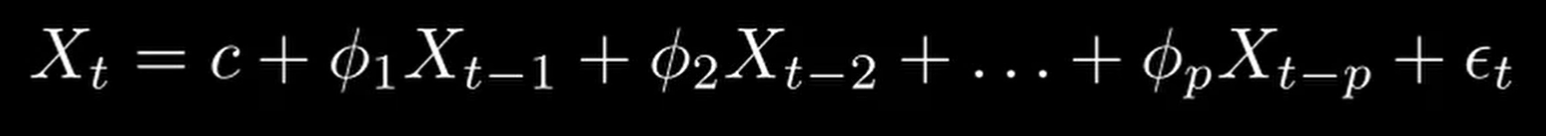

Les modèles autoregressifs fonctionne sur des données stationnaires. Pour cela on fait un test ADF (Augmented Dickey-Fuller).

p-value > 0.05: on ne peut pas rejeter l'hypothèse nulle, la série n'est pas stationnaire.

p-value < 0.05: on rejette l'hypothèse nulle, la série est stationnaire.

In [150]:
data = pd.read_parquet("C:\\Users\\tariq\\algorithmic_trading\\5min_perp\\BTC_USDT_USDT.parquet")
data["datetime"] = pd.to_datetime(data["date"])
data = data.set_index(['datetime'])

#logreturns
data['logreturns'] = np.log(data['close'] / data['close'].shift(1))
data.dropna(inplace=True)
data.head()

,date,open,high,low,close,volume,logreturns
datetime,,,,,,,
2020-01-01 00:05:00,2020-01-01 00:05:00,7174.71,7186.69,7173.28,7186.69,163.860,0.001593
2020-01-01 00:10:00,2020-01-01 00:10:00,7186.83,7188.10,7175.70,7176.26,290.358,-0.001452
2020-01-01 00:15:00,2020-01-01 00:15:00,7176.22,7179.41,7172.43,7173.68,189.617,-0.000360
2020-01-01 00:20:00,2020-01-01 00:20:00,7173.50,7176.13,7170.69,7171.81,198.838,-0.000261
2020-01-01 00:25:00,2020-01-01 00:25:00,7172.00,7179.04,7170.98,7172.36,319.378,0.000077


In [41]:
def check_stationarity(series):
    # Copied from https://machinelearningmastery.com/time-series-data-stationary-python/
    result = adfuller(series.values)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

check_stationarity(data['logreturns'])


ADF Statistic: -75.224975
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567
Stationary


autre idées : bootstrapping, crossvalidating etc

In [151]:
train_size = 0.7
data_train = data.copy().iloc[:int(len(data) * train_size)]
data_test = data.copy().iloc[int(len(data) * train_size):]

corrélogramme, fonction d'autocorrélation partielle.

cela affiche l'autocorrélation entre les logreturn et les logreturns laggés.

l'autocorrélation partielle isole l'effet de la variable laggée sur la variable actuelle (contrairement a l'autocorrélation qui prend en compte toutes les variables laggées sans isolation).


,lag,PACF,lower_bounds,upper_bounds
1,1,-0.036858,-0.043116,-0.030599
2,2,-0.015998,-0.022257,-0.009740
3,3,0.013368,0.007109,0.019626
4,4,-0.008482,-0.014740,-0.002223
5,5,-0.023569,-0.029827,-0.017310
6,6,-0.021379,-0.027638,-0.015121
7,7,0.006596,0.000337,0.012854
11,11,0.008157,0.001898,0.014415
15,15,-0.009244,-0.015502,-0.002985
26,26,-0.006771,-0.013030,-0.000513


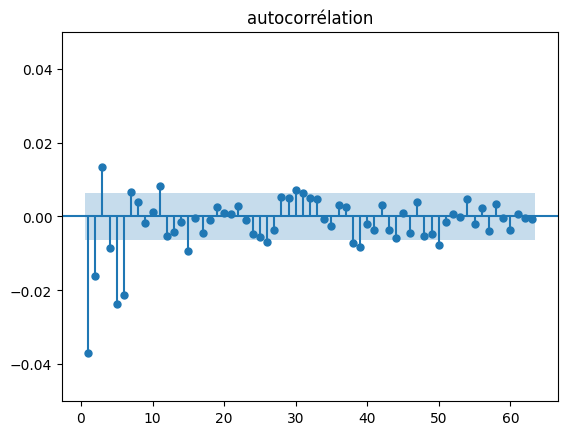

In [55]:
def compute_pacf(data, nlags, alpha): 
    serie = data["logreturns"]
    n = len(serie)
    z = norm.ppf(1 - alpha / 2)
    pacf_vals = pacf(serie, nlags=nlags, method="ywm") 
    #intervall de confiance
    conf_interval =  norm.ppf(1 - alpha / 2) / np.sqrt(n)
    lower_bounds = pacf_vals - conf_interval
    upper_bounds = pacf_vals + conf_interval

    significant = (pacf_vals < -conf_interval) | (pacf_vals > conf_interval)
    df = pd.DataFrame({
        "lag": range(len(pacf_vals)), 
        "PACF": pacf_vals,
        "lower_bounds": lower_bounds,
        "upper_bounds": upper_bounds
    })
    df_significant = df[significant & (df["lag"] != 0)]
    return df_significant

df_pacf = compute_pacf(data_train, nlags=50, alpha=0.0001)
display(df_pacf)

fix, ax = plt.subplots()
plot_pacf(data_train['logreturns'], lags=63, ax=ax, alpha=0.0001, use_vlines=True, method='ywm', title='autocorrélation', zero=False)
ax.set_ylim(-0.05, 0.05)
plt.show()

# Calcul des autocorrélation partielles pour toutes les paires

In [59]:
data_path = "C:\\Users\\tariq\\algorithmic_trading\\5min_perp"
file_list = os.listdir(data_path)

alpha = 0.0001
nlags = 10

df_pacfs = {}
for file in tqdm(file_list):
    if file.endswith("USDT.parquet"):
        crypto_name = file.split("_")[0]
        data = pd.read_parquet(os.path.join(data_path, file))
        data["datetime"] = pd.to_datetime(data["date"])
        data = data.set_index(['datetime'])
        data['logreturns'] = np.log(data['close'] / data['close'].shift(1))
        data.dropna(inplace=True)
        df_pacf = compute_pacf(data, nlags=nlags, alpha=alpha)
        df_pacfs[crypto_name] = df_pacf

100%|██████████| 450/450 [00:20<00:00, 21.54it/s]


In [104]:
all_pacf_data = []
for crypto_name, df_pacf in df_pacfs.items():
    df_pacf = df_pacf[(df_pacf["PACF"] < 0.5) & (df_pacf["PACF"] > -0.5)]    
    df_pacf["crypto"] = crypto_name    
    all_pacf_data.append(df_pacf)

big_pacf_df = pd.concat(all_pacf_data, ignore_index=True)
big_pacf_df = big_pacf_df[["crypto", "PACF", "lag"]]
big_pacf_df.sort_values(by=["PACF"], ascending=False)

,crypto,PACF,lag
1075,USDC,0.132834,1
230,BROCCOLI714,0.123280,2
462,FORM,0.098734,5
232,BROCCOLIF3B,0.089191,3
231,BROCCOLIF3B,0.079927,2
...,...,...,...
233,BROCCOLIF3B,-0.107186,6
1123,XEM,-0.135202,1
801,PAXG,-0.143395,1
99,ANIME,-0.163781,1


In [114]:
big_pacf_df.sort_values(by=["PACF"], ascending=True)

,crypto,PACF,lag
229,BROCCOLI714,-0.167986,1
99,ANIME,-0.163781,1
801,PAXG,-0.143395,1
1123,XEM,-0.135202,1
233,BROCCOLIF3B,-0.107186,6
...,...,...,...
231,BROCCOLIF3B,0.079927,2
232,BROCCOLIF3B,0.089191,3
462,FORM,0.098734,5
230,BROCCOLI714,0.123280,2


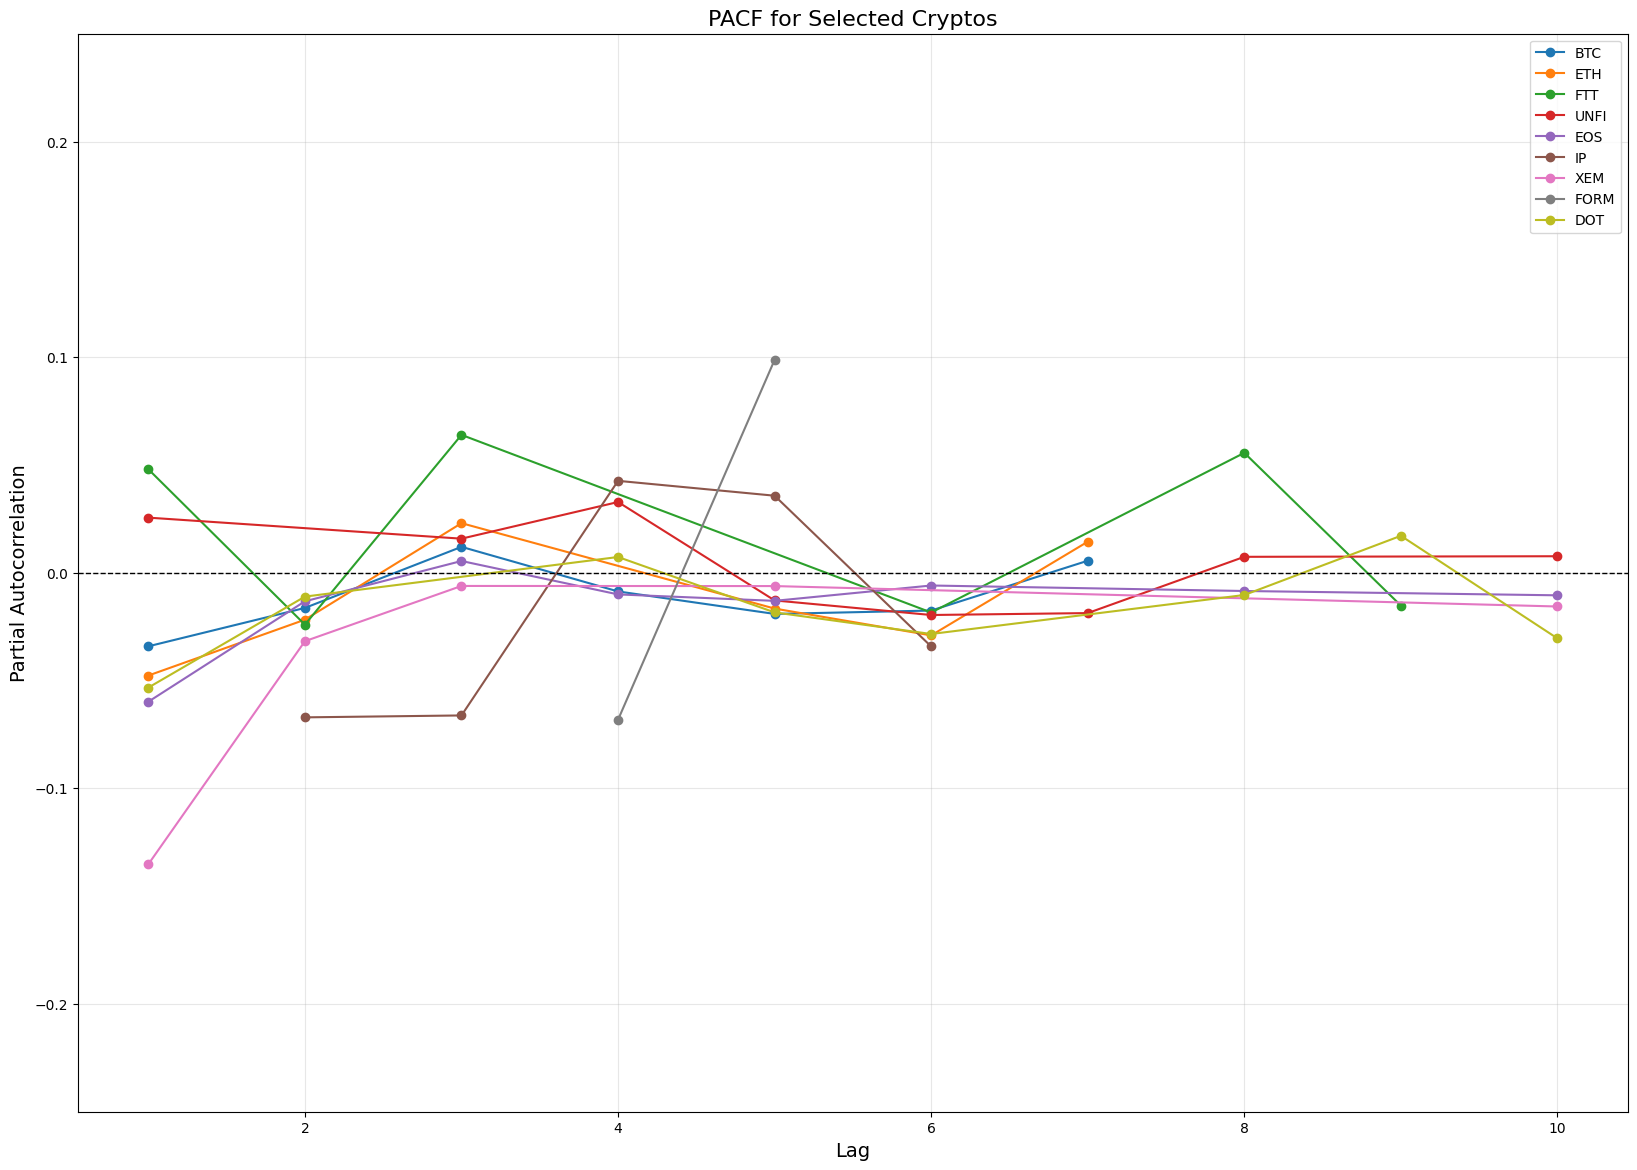

In [122]:
plot_pacf_lag(["BTC", "ETH", "FTT", "UNFI", 'EOS', 'IP', "XEM", "FORM", "DOT"], big_pacf_df)

# test sur btc

on prends les 6 derniers lags.

In [152]:
lags = list(range(1, 7))
for lag in lags : 
    data_train[f"log_returns_lag_{lag}"] = data_train["logreturns"].shift(lag)
    data_test[f"log_returns_lag_{lag}"] = data_test["logreturns"].shift(lag)

data_train.dropna(inplace=True)
data_test.dropna(inplace=True)

In [153]:
data_train

,date,open,high,low,close,volume,logreturns,log_returns_lag_1,log_returns_lag_2,log_returns_lag_3,log_returns_lag_4,log_returns_lag_5,log_returns_lag_6
datetime,,,,,,,,,,,,,
2020-01-01 00:35:00,2020-01-01 00:35:00,7175.76,7176.37,7170.61,7172.80,101.815,-0.000414,0.000475,0.000077,-0.000261,-0.000360,-0.001452,0.001593
2020-01-01 00:40:00,2020-01-01 00:40:00,7172.98,7176.23,7171.96,7174.83,67.317,0.000283,-0.000414,0.000475,0.000077,-0.000261,-0.000360,-0.001452
2020-01-01 00:45:00,2020-01-01 00:45:00,7174.51,7177.11,7174.50,7177.11,27.889,0.000318,0.000283,-0.000414,0.000475,0.000077,-0.000261,-0.000360
2020-01-01 00:50:00,2020-01-01 00:50:00,7177.11,7179.36,7170.15,7172.73,208.199,-0.000610,0.000318,0.000283,-0.000414,0.000475,0.000077,-0.000261
2020-01-01 00:55:00,2020-01-01 00:55:00,7172.15,7175.31,7170.20,7171.55,142.545,-0.000165,-0.000610,0.000318,0.000283,-0.000414,0.000475,0.000077
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-02 11:25:00,2023-09-02 11:25:00,25840.20,25840.20,25799.10,25813.10,1499.782,-0.001045,-0.000035,0.000101,0.000004,0.000132,0.000577,0.000155
2023-09-02 11:30:00,2023-09-02 11:30:00,25813.10,25826.00,25812.40,25825.90,310.406,0.000496,-0.001045,-0.000035,0.000101,0.000004,0.000132,0.000577
2023-09-02 11:35:00,2023-09-02 11:35:00,25826.00,25839.70,25819.20,25824.80,259.478,-0.000043,0.000496,-0.001045,-0.000035,0.000101,0.000004,0.000132


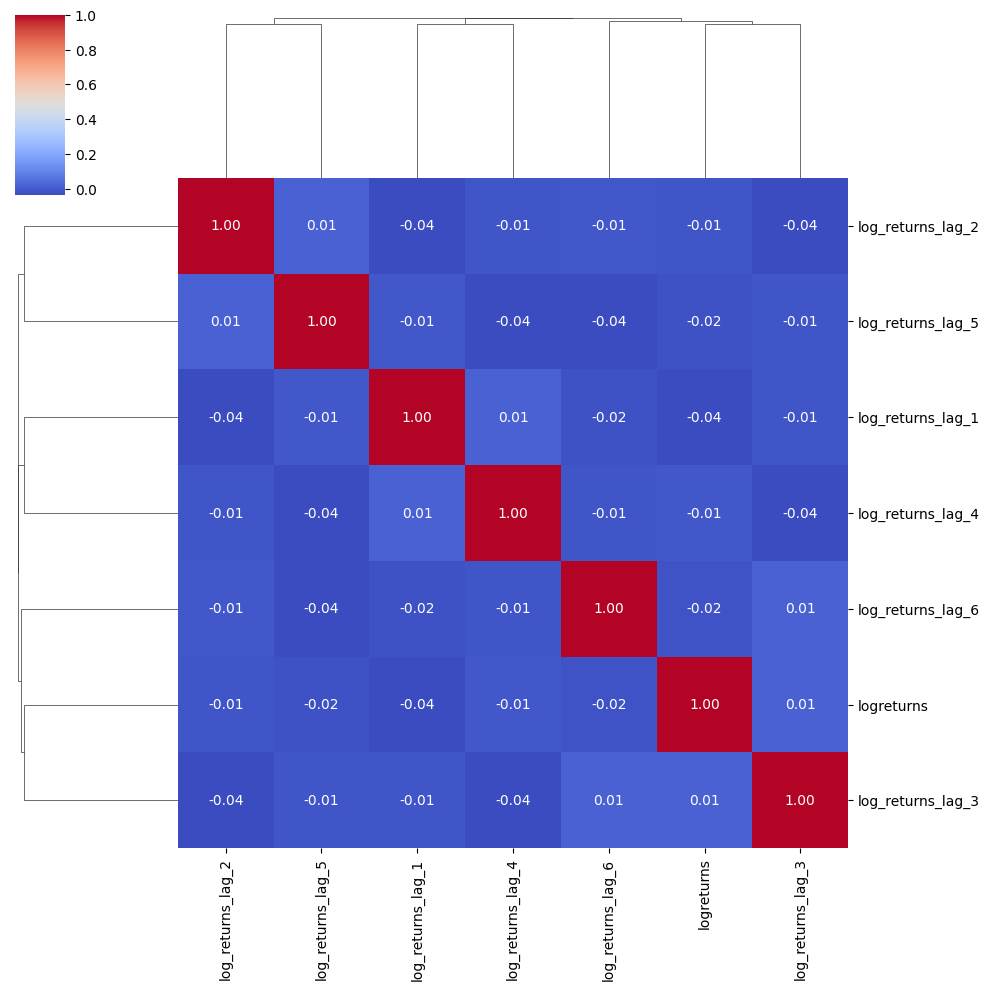

In [154]:
sns.clustermap(data_train[[c for c in data_train.columns if "returns" in c]].corr(), cmap="coolwarm", annot=True, fmt=".2f"
               )

### regression linéaire

In [155]:
y = data_train["logreturns"]
x = add_constant(data_train[[c for c in data_train.columns if "lag" in c]])

In [156]:
phis = np.linalg.lstsq(x, y, rcond=None)[0]
print(phis)

[ 3.62769298e-06 -3.78234582e-02 -1.55215690e-02  1.29550021e-02
 -9.68410740e-03 -2.43672254e-02 -2.13794869e-02]


In [157]:
x @ phis

datetime
2020-01-01 00:35:00   -0.000014
2020-01-01 00:40:00    0.000055
2020-01-01 00:45:00    0.000019
2020-01-01 00:50:00   -0.000019
2020-01-01 00:55:00    0.000016
                         ...   
2023-09-02 11:25:00   -0.000015
2023-09-02 11:30:00    0.000029
2023-09-02 11:35:00   -0.000003
2023-09-02 11:40:00   -0.000018
2023-09-02 11:45:00    0.000061
Length: 386441, dtype: float64

<Axes: title={'center': 'reg coefs'}, ylabel='None'>

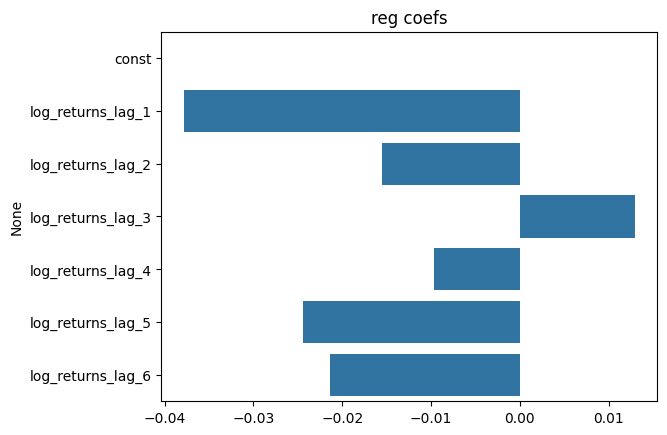

In [158]:
plt.title("reg coefs")
sns.barplot(x=phis, y =x.columns)

In [159]:
# 2eme type de régression linéaire pour avoir les statistiques
model = OLS(endog=y, exog=x)
model = model.fit()
model.summary() 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             logreturns   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     185.7
Date:              dim., 06 avr. 2025   Prob (F-statistic):          4.12e-237
Time:                        21:35:30   Log-Likelihood:             1.7926e+06
No. Observations:              386441   AIC:                        -3.585e+06
Df Residuals:                  386434   BIC:                        -3.585e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.628e-06   3.76e-06      0.964      0.335   -3.75e-06     1.1e-05
log_returns_lag_1    -0.0378      0.002    -23.518      0.000      -0.041      -0.035
log_returns_lag_2    -0.0155      0.002     -9.647      0.000      -0.019      -0.012
log_returns_lag_3     0.0130      0.002      8.051      0.000       0.010       0.016
log_returns_lag_4    -0.0097      0.002     -6.018      0.000      -0.013      -0.007
log_returns_lag_5    -0.0244      0.002    -15.145      0.000      -0.028      -0.021
log_returns_lag_6    -0.0214      0.002    -13.293      0.000      -0.025      -0.018
==============================================================================
Omnibus:                   183401.469   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        405670475.493
Skew:                          -0.595   Prob(JB):                         0.00
Kurtosis:                     161.723   Cond. No.                         445.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
data_train["pred"] = x @ phis

on garde les prévisions extremes, les 20 % les plus basses et hautes

In [161]:
lower = data_train["pred"].quantile(0.2)
higher = data_train["pred"].quantile(0.8)

x_tremdata = data_train[(data_train["pred"] < lower) | (data_train["pred"] > higher)]

In [163]:
from scipy.stats import pearsonr
pearsonr(x_tremdata["logreturns"], x_tremdata["pred"])

PearsonRResult(statistic=0.06271486906412922, pvalue=1.7037121538315125e-134)

In [165]:
x_tremdata  = x_tremdata.sort_values(by=["pred"])

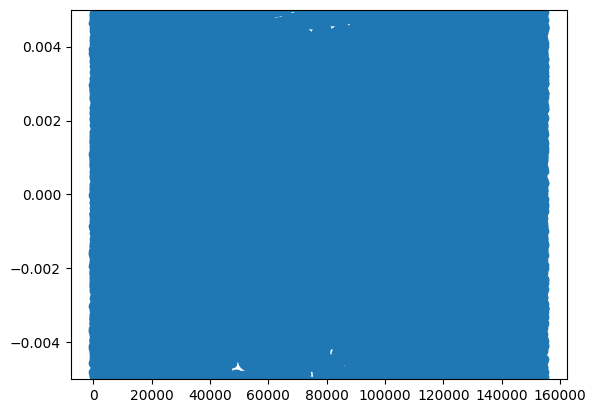

In [167]:
plt.ylim([-0.005, 0.005])
plt.scatter(np.arange(len(x_tremdata)), x_tremdata["logreturns"])

### backtest

In [168]:
data_test["pred"] = add_constant(data_test[[c for c in data_test.columns if "lag" in c]]) @ phis

In [170]:
print(higher, lower)

6.102273524309753e-05 -5.553145407344202e-05


In [171]:
data_test["signal"] = np.where(data_test["pred"] > higher, 1, 0)
data_test["signal"] = np.where(data_test["pred"] < lower, -1, data_test["signal"])

In [178]:
data_test["backtest"] = data_test['signal'] * (np.exp(data_test['logreturns']) - 1)
data_test["buy_hold"] = (1+ (np.exp(data_test['logreturns']) - 1)).cumprod()


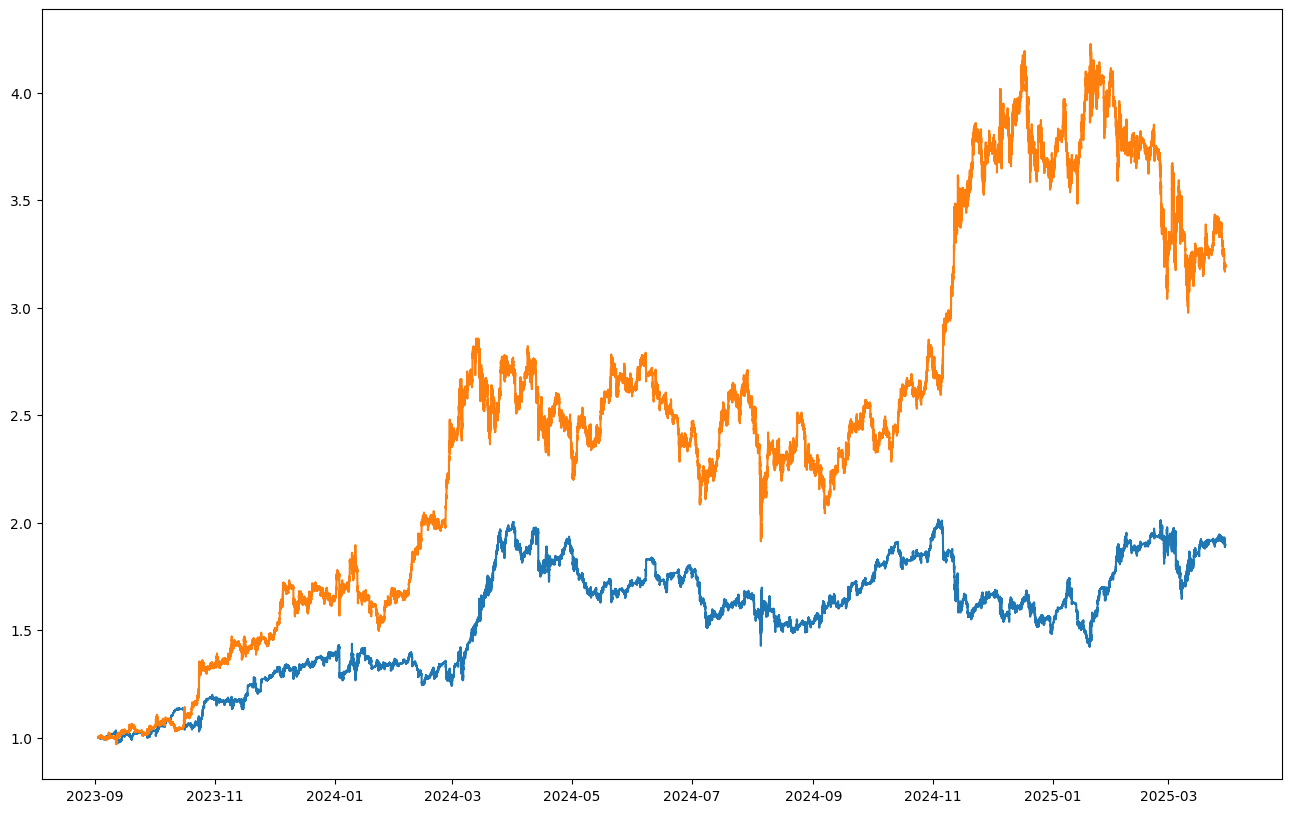

In [179]:
plt.figure(figsize=(16, 10))
plt.plot(data_test["date"], (1+ data_test["backtest"].values).cumprod() )
plt.plot(data_test["date"], data_test["buy_hold"].values)